# Brexit Polarity Tweets - Exploratory Analysis

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
PATH_DATA = "./data/"
PATH_ANTI = PATH_DATA + 'raw/TweetDataset_AntiBrexit_Jan-Mar2022.csv'
PATH_PRO  = PATH_DATA + 'raw/TweetDataset_ProBrexit_Jan-Mar2022.csv'

## Import Data

In [3]:
# import Data
nrows = None

pro  = pd.read_csv(PATH_PRO, nrows = nrows)
anti = pd.read_csv(PATH_ANTI, nrows = nrows)

anti["Status"] = "Anti"
pro["Status"] = "Pro"

pro.shape, anti.shape

((147631, 39), (210574, 39))

In [4]:
# check if the csv files has the same column names types  
assert np.all(pro.dtypes == anti.dtypes)
assert np.all(pro.columns == anti.columns)

In [5]:
# combine data
df = pd.concat([anti, pro], ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358205 entries, 0 to 358204
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             358205 non-null  int64  
 1   Date                   358205 non-null  object 
 2   Headline               0 non-null       float64
 3   URL                    358205 non-null  object 
 4   Opening Text           0 non-null       float64
 5   Hit Sentence           358205 non-null  object 
 6   Source                 358205 non-null  object 
 7   Influencer             358205 non-null  object 
 8   Country                358205 non-null  object 
 9   Subregion              0 non-null       float64
 10  Language               358205 non-null  object 
 11  Reach                  358205 non-null  int64  
 12  Desktop Reach          358205 non-null  int64  
 13  Mobile Reach           358205 non-null  int64  
 14  Twitter Social Echo    0 non-null   

In [6]:
# filter columns
irrelevant_cols = ["Unnamed: 0", "Source", "Time", "Alternate Date Format"]

# remove columns with no data
non_null_cols = df.apply(lambda col: np.all(col.isna()))
non_null_cols = np.invert(non_null_cols)

df = df.drop(irrelevant_cols, axis = 1)
df = df.loc[:, non_null_cols]

In [7]:
# remove duplicated tweets
df = df.drop_duplicates(subset = "Tweet Id")

## Data Cleaning

### Date and Time

In [8]:
df["DateTime"] = pd.to_datetime(df["Date"])
df["Time"] = df["DateTime"].dt.time
df["Date"] = df["DateTime"].dt.date

### State

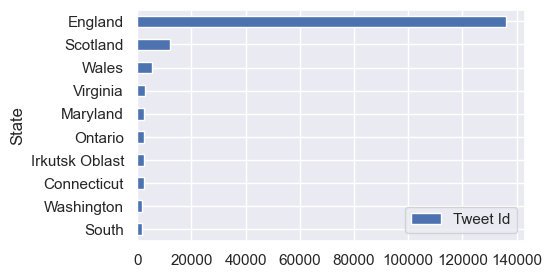

In [9]:
state = df.groupby(["State"]) \
    .agg({"Tweet Id": "count"}) \
    .sort_values("Tweet Id") \
    .tail(10)
    
state.plot(kind = "barh", figsize = (5, 3))
plt.legend(loc = "lower right")
plt.show()

In [10]:
#fill null values in state with modes
df['State'].fillna(df['State'].mode()[0],inplace=True)

### Twitter Authority, Followers and Following

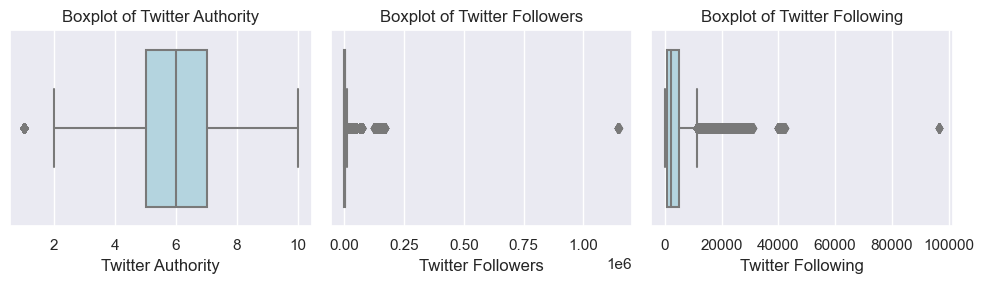

In [11]:
# see the distribution of twitter authority data, twitter followers data, and twitter following 
# data using boxplot for knowing what should we deal with outliers and null values.
list_of_columns = ['Twitter Authority','Twitter Followers','Twitter Following']

plt.figure(figsize=(10, 3))

for i in range(len(list_of_columns)):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x = list_of_columns[i], data = df, color = 'lightblue')
    plt.title('Boxplot of {}'.format(list_of_columns[i]))
    plt.tight_layout()

plt.show()

In [12]:
# Remove outliers
df = df[df['Twitter Following'] < 900000]
df = df[df['Twitter Followers'] < 90000]
df = df[df['Twitter Authority'] > 1.5]

# fill Twitter Authority nan values with mean
df['Twitter Authority'].fillna(df['Twitter Authority'].mean(),inplace=True)

# fill Twitter Following and Following with median
df['Twitter Following'].fillna(df['Twitter Followers'].median(),inplace=True)
df['Twitter Following'].fillna(df['Twitter Following'].median(),inplace=True)

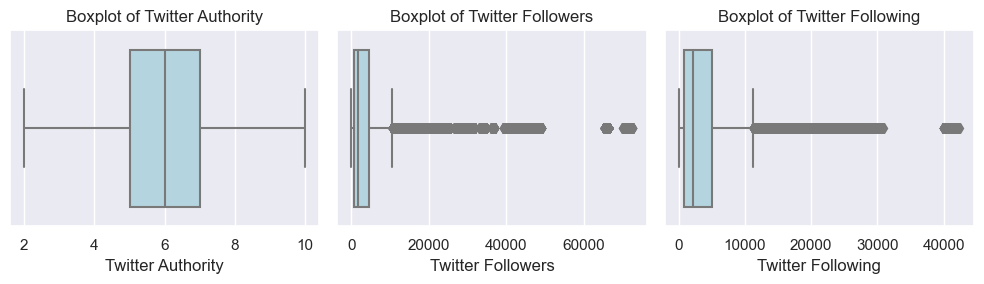

In [13]:
# see the distribution of twitter authority data, twitter followers data, and twitter following 
# data using boxplot for knowing what should we deal with outliers and null values.
list_of_columns = ['Twitter Authority','Twitter Followers','Twitter Following']

plt.figure(figsize=(10, 3))

for i in range(len(list_of_columns)):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x = list_of_columns[i], data = df, color = 'lightblue')
    plt.title('Boxplot of {}'.format(list_of_columns[i]))
    plt.tight_layout()

plt.show()

### Exploratory Analysis

In [14]:
effectiveness = df.groupby(["Twitter Authority"]) \
      .agg({"AVE": "mean",
            "Twitter Following": "mean",
            "Twitter Followers": "mean"}) \
      .agg({"AVE": (lambda x: 100 * x / sum(x)),
            "Twitter Following": (lambda x: 100 * x / sum(x)),
            "Twitter Followers": (lambda x: 100 * x / sum(x))}) \
      .reset_index()

In [15]:
effectiveness

,Twitter Authority,AVE,Twitter Following,Twitter Followers
0,2.0,0.020251,0.316450,0.020251
1,3.0,0.053979,0.440349,0.053979
2,4.0,0.149379,0.942085,0.149361
3,5.0,0.420587,1.874974,0.420585
4,6.0,1.352343,5.132798,1.352339
5,7.0,3.808753,10.545948,3.808748
6,8.0,12.099036,32.367333,12.099037
7,9.0,31.927244,38.507590,31.927263
8,10.0,50.168429,9.872472,50.168437


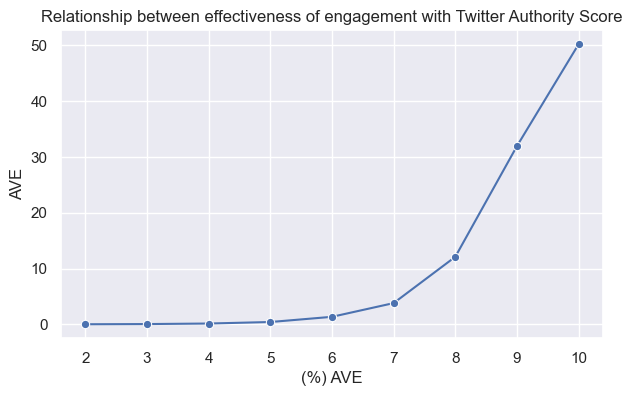

In [16]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.lineplot(x = "Twitter Authority", y = "AVE", data = effectiveness, marker = "o")

plt.title('Relationship between effectiveness of engagement with Twitter Authority Score')
plt.xlabel("(%) AVE")
plt.show()

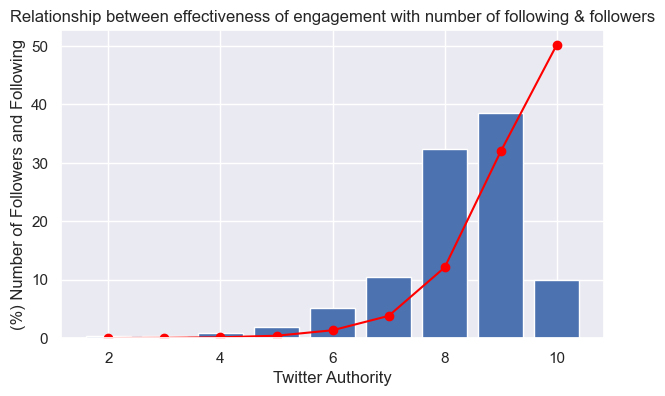

In [17]:
# From dataframe above, create a visualization for easier analysis 
plt.figure(figsize=(7, 4))

plt.bar("Twitter Authority", "Twitter Following", data = effectiveness, label = "Following")
plt.plot("Twitter Authority", "Twitter Followers", data = effectiveness, c = "red", marker = "o", 
         label = "Followers")

plt.title('Relationship between effectiveness of engagement with number of following & followers')
plt.xlabel('Twitter Authority')
plt.ylabel('(%) Number of Followers and Following')
plt.legend
plt.show()

### Tweet Polarity

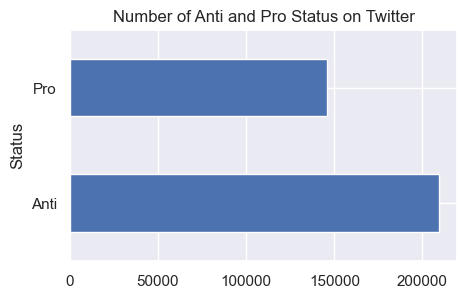

In [18]:
# Create visualization of number of pro's and anti's tweets
df.groupby(['Status']).agg({'Tweet Id':['count']}).plot(kind='barh',figsize=(5, 3), legend = None) 

plt.title('Number of Anti and Pro Status on Twitter')
plt.show()

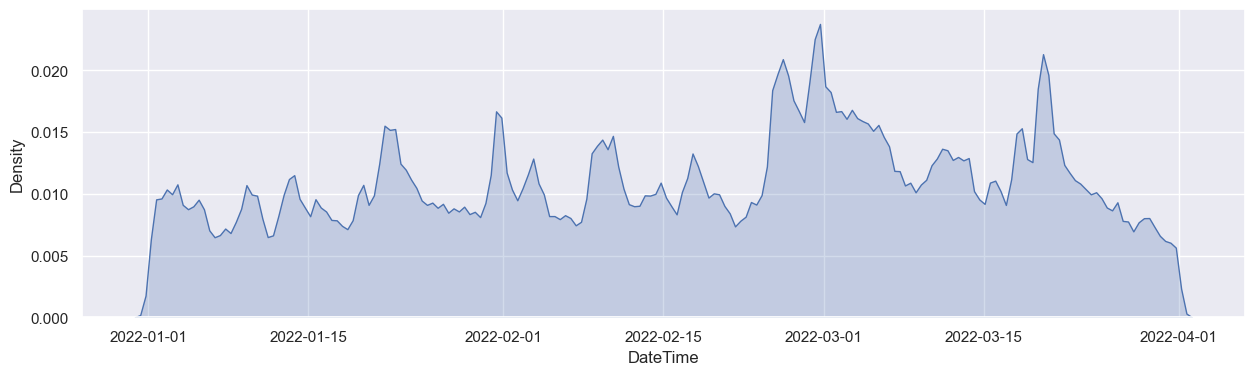

In [19]:
plt.figure(figsize = (15, 4))
sns.kdeplot(x = "DateTime", data = df, fill = "DateTime", bw_adjust=0.2)
plt.show()

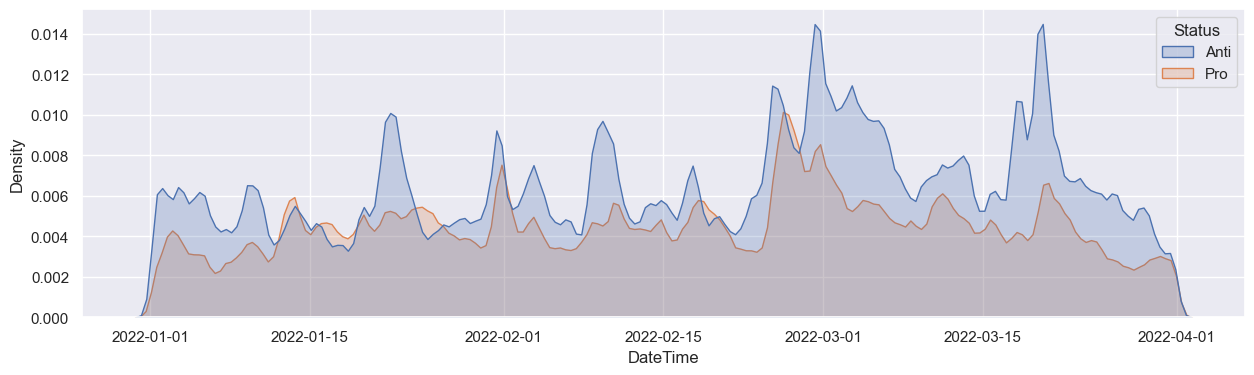

In [20]:
plt.figure(figsize = (15, 4))
sns.kdeplot(x = "DateTime", hue = "Status", data = df, fill = "Status", bw_adjust=0.2)
plt.show()

In [21]:
df["Time"] = "2000-01-01 " + pd.to_datetime(df["DateTime"]).dt.time.astype(str)
df["Time"] = pd.to_datetime(df["Time"])

sns.set(rc={'figure.figsize':(7, 4)})

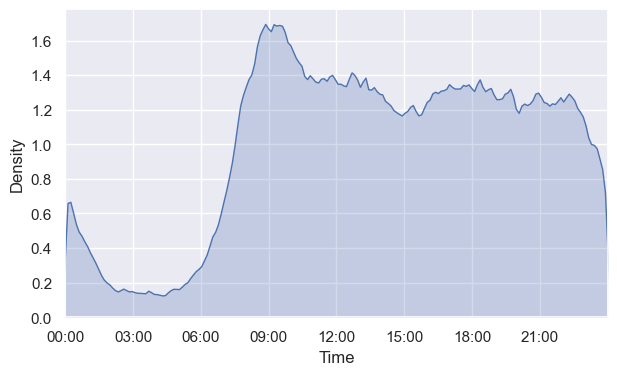

In [22]:
from matplotlib import dates as mdates

plt.figure(figsize = (7, 4))

ax = sns.kdeplot(x = "Time", data = df, fill = "Time", bw_adjust=0.2)

ax.set_xlim([pd.to_datetime('2000-01-01 00:00:00'),
             pd.to_datetime('2000-01-01 23:59:59')])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()

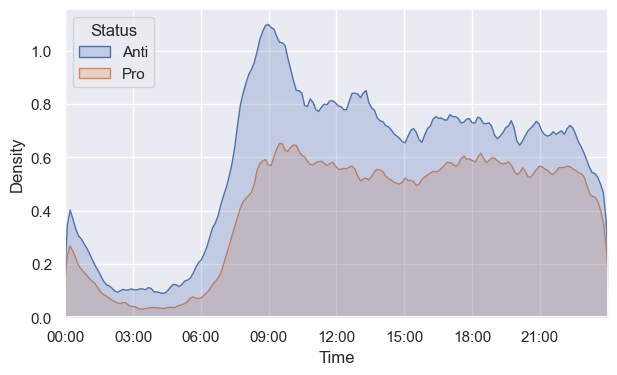

In [23]:
from matplotlib import dates as mdates

plt.figure(figsize = (7, 4))

ax = sns.kdeplot(x = "Time", hue = "Status", data = df, fill = "Status", bw_adjust=0.2)

ax.set_xlim([pd.to_datetime('2000-01-01 00:00:00'),
             pd.to_datetime('2000-01-01 23:59:59')])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

sns.move_legend(ax, "upper left")
plt.show()

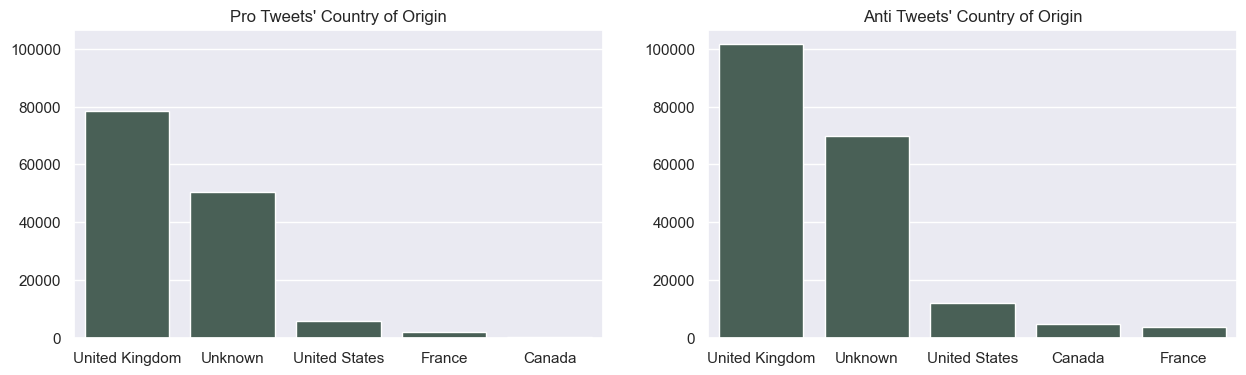

In [24]:
top_countries = df.groupby("Country").agg({"Tweet Id": "count"}) \
    .sort_values("Tweet Id", ascending = False).head(5).index.values

country = df.groupby(["Country", "Status"], as_index = False)
country = country.agg({"Tweet Id": "count"})
country = country.iloc[np.isin(country["Country"], top_countries), :]
country = country.sort_values("Tweet Id", ascending = False)
country

plt.figure(figsize = (15, 4))

for i, status in enumerate(["Pro", "Anti"]):
    plt.subplot(1, 2, i+1)
    sns.barplot(x = "Country", y = "Tweet Id", color = "#456456", 
                data = country.loc[country["Status"] == status])
    plt.ylim(top = country["Tweet Id"].max() * 1.05)
    plt.title(f"{status} Tweets' Country of Origin")
    plt.ylabel(None)
    plt.xlabel(None)

plt.show()

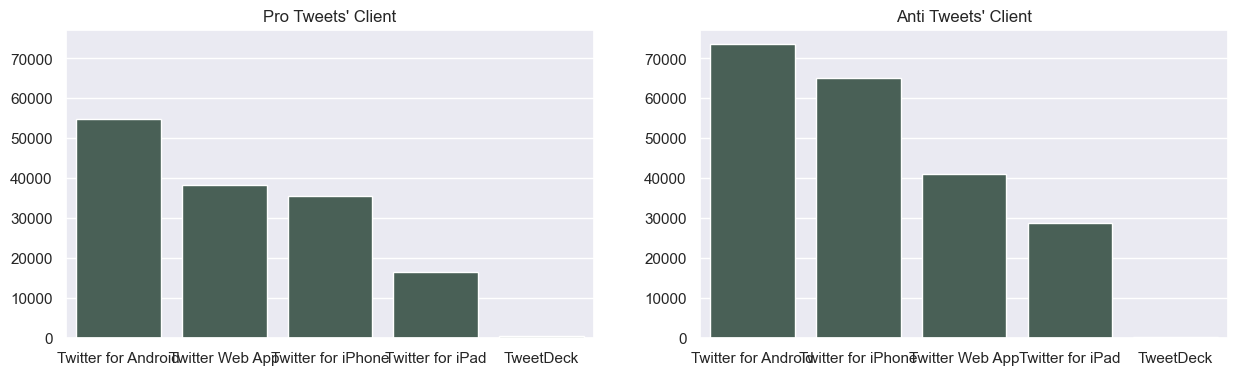

In [25]:
top_devices = df.groupby("Twitter Client").agg({"Tweet Id": "count"}) \
    .sort_values("Tweet Id", ascending = False).head(5).index.values

devices = df.groupby(["Twitter Client", "Status"], as_index = False)
devices = devices.agg({"Tweet Id": "count"})
devices = devices.iloc[np.isin(devices["Twitter Client"], top_devices), :]
devices = devices.sort_values("Tweet Id", ascending = False)
devices

plt.figure(figsize = (15, 4))

for i, status in enumerate(["Pro", "Anti"]):
    plt.subplot(1, 2, i+1)
    sns.barplot(x = "Twitter Client", y = "Tweet Id", color = "#456456", 
                data = devices.loc[devices["Status"] == status])
    plt.ylim(top = devices["Tweet Id"].max() * 1.05)
    plt.title(f"{status} Tweets' Client")
    plt.ylabel(None)
    plt.xlabel(None)

plt.show()

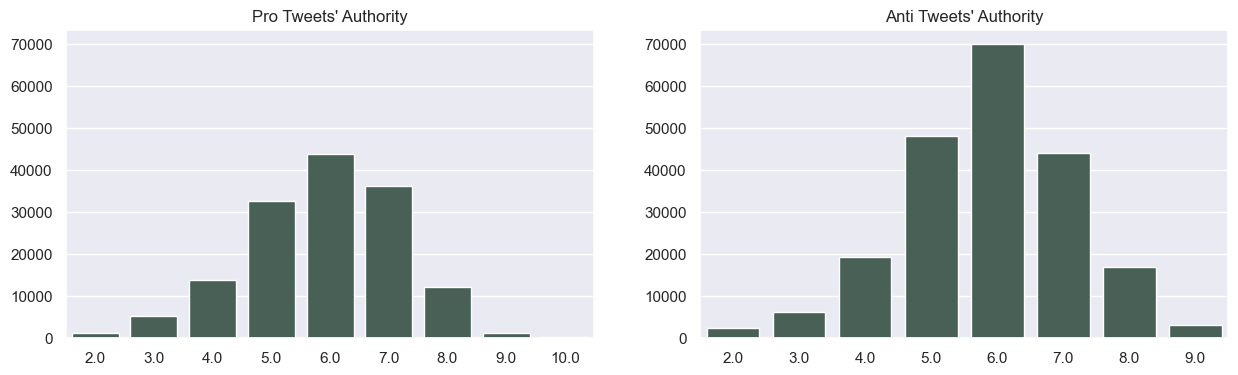

In [26]:
authority = df.groupby(["Twitter Authority", "Status"], as_index = False)
authority = authority.agg({"Tweet Id": "count"})
authority = authority.sort_values("Tweet Id", ascending = False)
authority

plt.figure(figsize = (15, 4))

for i, status in enumerate(["Pro", "Anti"]):
    plt.subplot(1, 2, i+1)
    sns.barplot(x = "Twitter Authority", y = "Tweet Id", color = "#456456", 
                data = authority.loc[authority["Status"] == status])
    plt.ylim(top = authority["Tweet Id"].max() * 1.05)
    plt.title(f"{status} Tweets' Authority")
    plt.ylabel(None)
    plt.xlabel(None)

plt.show()

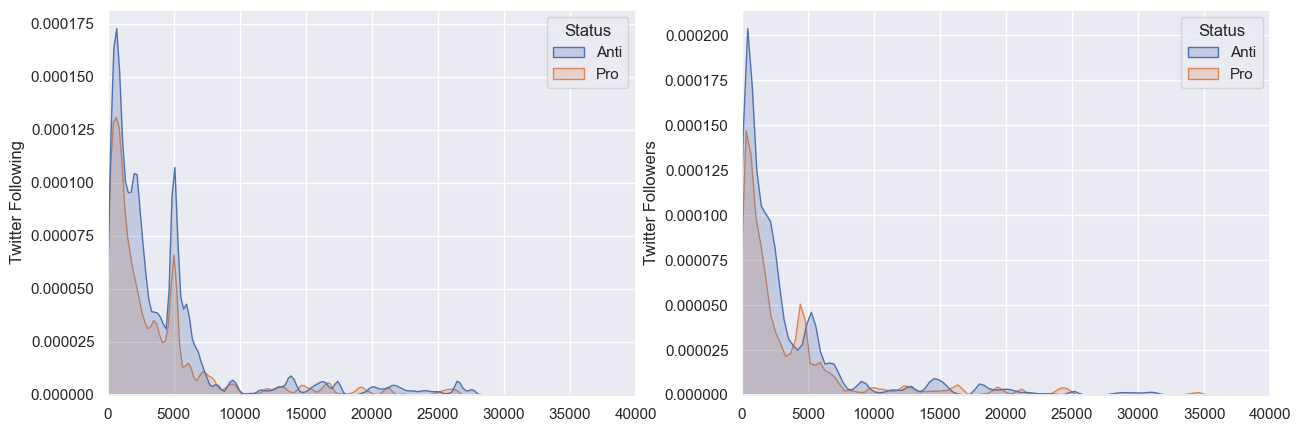

In [27]:
plt.figure(figsize=(15, 5))

for i, column in enumerate(["Twitter Following", "Twitter Followers"]):
    plt.subplot(1, 2, i+1)
    sns.kdeplot(x = column, hue = "Status", fill = "Status", data = df, bw_adjust = 0.5)
    plt.xlim(0, 4e4)
    plt.ylabel(column)
    plt.xlabel(None)